# CNN WITH 1D DATA

In [2]:
from __future__ import print_function
  
from keras.models import Model
from keras.layers import Input, Dense, merge, Activation
from keras.utils import np_utils
import numpy as np
import keras 
from keras.callbacks import ReduceLROnPlateau
from pyts.transformation import GASF, GADF, MTF, RecurrencePlots    # should be in pyts.image module?
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(813306)

d:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def build_resnet(input_shape, n_feature_maps, nb_classes):
    print ('build conv_x')
    x = Input(shape=(input_shape))
    print("input shape",input_shape)
    
    conv_x = keras.layers.normalization.BatchNormalization()(x)
    conv_x = keras.layers.Conv2D(n_feature_maps, 8, 1, border_mode='same')(conv_x)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps, 5, 1, border_mode='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps, 3, 1, border_mode='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps, 1, 1,border_mode='same')(x)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.normalization.BatchNormalization()(x)
    print ('Merging skip connection')
    y = merge([shortcut_y, conv_z], mode='sum')
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, border_mode='same')(x1)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, border_mode='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, border_mode='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)
     
    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,border_mode='same')(x1)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.normalization.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = merge([shortcut_y, conv_z], mode='sum')
    y = Activation('relu')(y)
     
    print ('build conv_x')
    x1 = y
    conv_x = keras.layers.Conv2D(n_feature_maps*2, 8, 1, border_mode='same')(x1)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
     
    print ('build conv_y')
    conv_y = keras.layers.Conv2D(n_feature_maps*2, 5, 1, border_mode='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
     
    print ('build conv_z')
    conv_z = keras.layers.Conv2D(n_feature_maps*2, 3, 1, border_mode='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

    is_expand_channels = not (input_shape[-1] == n_feature_maps*2)
    if is_expand_channels:
        shortcut_y = keras.layers.Conv2D(n_feature_maps*2, 1, 1,border_mode='same')(x1)
        shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)
    else:
        shortcut_y = keras.layers.normalization.BatchNormalization()(x1)
    print ('Merging skip connection')
    y = merge([shortcut_y, conv_z], mode='sum')
    y = Activation('relu')(y)
     
    full = keras.layers.pooling.GlobalAveragePooling2D()(y)   
    out = Dense(nb_classes, activation='softmax')(full)
    print ('        -- model was built.')
    return x, out

#flist = ['Adiac', 'Beef', 'CBF', 'ChlorineConcentration', 'CinC_ECG_torso', 'Coffee', 'Cricket_X', 'Cricket_Y', 'Cricket_Z', 
#'DiatomSizeReduction', 'ECGFiveDays', 'FaceAll', 'FaceFour', 'FacesUCR', '50words', 'FISH', 'Gun_Point', 'Haptics', 
#'InlineSkate', 'ItalyPowerDemand', 'Lighting2', 'Lighting7', 'MALLAT', 'MedicalImages', 'MoteStrain', 'NonInvasiveFatalECG_Thorax1', 
#'NonInvasiveFatalECG_Thorax2', 'OliveOil', 'OSULeaf', 'SonyAIBORobotSurface', 'SonyAIBORobotSurfaceII', 'StarLightCurves', 'SwedishLeaf', 'Symbols', 
#'synthetic_control', 'Trace', 'TwoLeadECG', 'Two_Patterns', 'uWaveGestureLibrary_X', 'uWaveGestureLibrary_Y', 'uWaveGestureLibrary_Z', 'wafer', 'WordsSynonyms', 'yoga']


In [4]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    #print(data[0:100])
    Y = data[:,0]
    X = data[:,1:]
    #print(X[0:100])
    return X, Y
   
nb_epochs = 150

In [22]:
def loaddataset():
    # root="D:\\dataset\\"
    root = "..\\data\\"
    fname = 'ECG200'
    x_train, y_train = readucr(root+fname+'\\'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(root+fname+'\\'+fname+'_TEST.txt')
    return x_train,y_train,x_test,y_test

In [23]:
x_train,y_train,x_test,y_test=loaddataset()

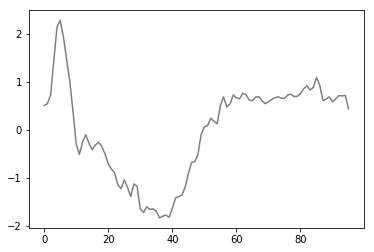

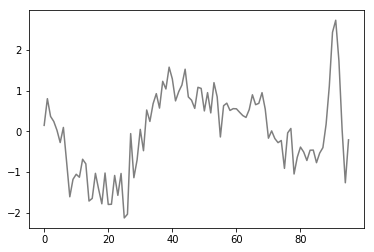

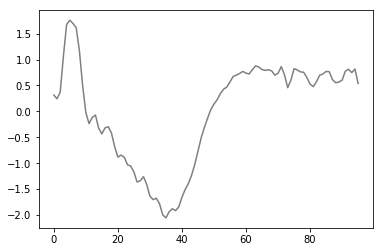

[-1.  1. -1.]


In [24]:
from pyts.visualization import plot_ts
plot_ts(x_train[0])
plot_ts(x_train[1])
plot_ts(x_train[2])
print(y_train[0:3])

# Gramian Angular Field(GAF)

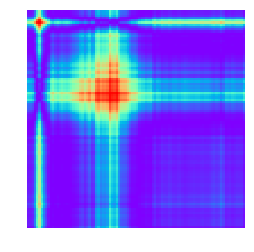

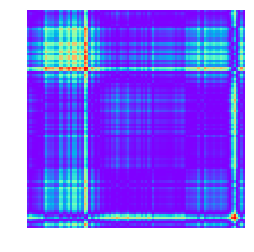

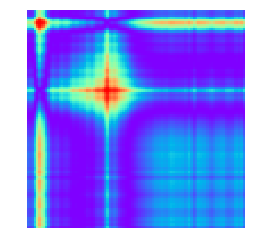

In [13]:
from pyts.visualization import plot_gasf

gasf=GASF(image_size=x_train.shape[1]//2, overlapping=False, scale='-1')
x_gasf=gasf.transform(x_train)
plot_gasf(x_train[0],image_size=x_train.shape[1],overlapping=False, scale='-1')
plot_gasf(x_train[1],image_size=x_train.shape[1],overlapping=False, scale='-1')
plot_gasf(x_train[2],image_size=x_train.shape[1],overlapping=False, scale='-1')


# Makov Transition FIeld(MTF)

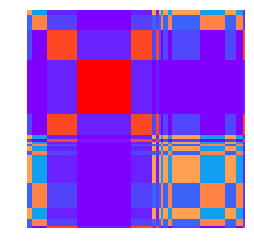

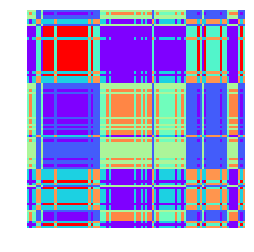

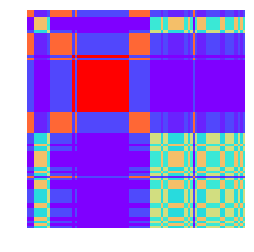

In [14]:
from pyts.visualization import plot_mtf

mtf=MTF(image_size=x_train.shape[1], n_bins=4, quantiles='empirical', overlapping=False)
X_mtf=mtf.transform(x_train)
plot_mtf(x_train[0], image_size=x_train.shape[1],n_bins=4, quantiles='empirical', overlapping=False)
plot_mtf(x_train[1], image_size=x_train.shape[1],n_bins=4, quantiles='empirical', overlapping=False)
plot_mtf(x_train[2], image_size=x_train.shape[1],n_bins=4, quantiles='empirical', overlapping=False)

# Recurrence Plot

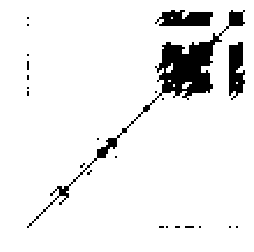

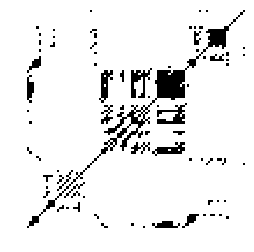

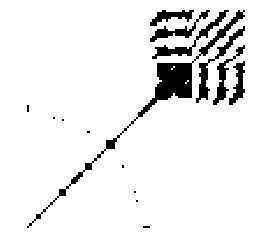

In [15]:
from pyts.visualization import plot_recurrence_plots
plot_recurrence_plots(x_train[0],dimension=3,epsilon='percentage_points',percentage=10)
plot_recurrence_plots(x_train[1],dimension=3,epsilon='percentage_points',percentage=10)
plot_recurrence_plots(x_train[2],dimension=3,epsilon='percentage_points',percentage=10)

rp=RecurrencePlots(dimension=3,epsilon='percentage_points',percentage=10)
x_rp=rp.transform(x_train)

In [25]:
def trainStep(method):
    
    x_train,y_train,x_test,y_test=loaddataset()
    
    if method =='GAF':
        gasf=GASF(image_size=x_train.shape[1]//2, overlapping=False, scale='-1')
        x_train=gasf.transform(x_train)
        x_test=gasf.transform(x_test)
        
    elif method =='MTF':
        mtf=MTF(image_size=x_train.shape[1], n_bins=4, quantiles='empirical', overlapping=False)
        x_train=mtf.transform(x_train)      
        x_test=mtf.transform(x_test) 
    elif method =='RP':
        rp=RecurrencePlots(dimension=3,epsilon='percentage_points',percentage=10)
        x_train=rp.transform(x_train)
        x_test=rp.transform(x_test)
        
        
    nb_classes = len(np.unique(y_test))
    batch_size = min(int(x_train.shape[0]/10), 16)
    
    # transform raw class vector to integers from 0 to num_classes
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

    # Converts a class vector (integers) to binary class matrix.
    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    # normalization
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)

    x_test = (x_test - x_train_mean)/(x_train_std)
    

    print("dimension before:",x_train.shape)
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.reshape(x_test.shape + (1,))
    print("dimension after:",x_train.shape)     # (100,96,1)


    x , y = build_resnet(x_train.shape[1:], 64, nb_classes)
    model = Model(input=x, output=y)
    optimizer = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                      patience=50, min_lr=0.0001) 
    
    print("train start....")

    hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), callbacks=[reduce_lr])

    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

   

dimension before: (100, 48, 48)
dimension after: (100, 48, 48, 1)
build conv_x
input shape (48, 48, 1)
build conv_y


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (8, 1), padding="same")`
  import sys
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 1), padding="same")`
  if sys.path[0] == '':
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`


build conv_z
Merging skip connection
build conv_x


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


build conv_y
build conv_z


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`


Merging skip connection
build conv_x
build conv_y


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


build conv_z
Merging skip connection
        -- model was built.
train start....


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 100 samples, validate on 100 samples
Epoch 1/150
 - 5s - loss: 0.5953 - acc: 0.7100 - val_loss: 0.5843 - val_acc: 0.7600
Epoch 2/150
 - 1s - loss: 0.4846 - acc: 0.8100 - val_loss: 2.6463 - val_acc: 0.6400
Epoch 3/150
 - 1s - loss: 0.3349 - acc: 0.8500 - val_loss: 3.1381 - val_acc: 0.6400
Epoch 4/150
 - 1s - loss: 0.2757 - acc: 0.8800 - val_loss: 3.6048 - val_acc: 0.6400
Epoch 5/150
 - 1s - loss: 0.2745 - acc: 0.8800 - val_loss: 3.0254 - val_acc: 0.6500
Epoch 6/150
 - 1s - loss: 0.1341 - acc: 0.9600 - val_loss: 1.0475 - val_acc: 0.8100
Epoch 7/150
 - 1s - loss: 0.1140 - acc: 0.9700 - val_loss: 2.6084 - val_acc: 0.6600
Epoch 8/150
 - 1s - loss: 0.1341 - acc: 0.9500 - val_loss: 1.0859 - val_acc: 0.7500
Epoch 9/150
 - 1s - loss: 0.1240 - acc: 0.9700 - val_loss: 1.2264 - val_acc: 0.7000
Epoch 10/150
 - 1s - loss: 0.1318 - acc: 0.9700 - val_loss: 0.6530 - val_acc: 0.7600
Epoch 11/150
 - 1s - loss: 0.0811 - acc: 0.9700 - val_loss: 2.2022 - val_acc: 0.6900
Epoch 12/150
 - 1s - loss: 0

Epoch 96/150
 - 1s - loss: 1.9274e-04 - acc: 1.0000 - val_loss: 1.4110 - val_acc: 0.8000
Epoch 97/150
 - 1s - loss: 6.2188e-04 - acc: 1.0000 - val_loss: 1.2419 - val_acc: 0.7800
Epoch 98/150
 - 1s - loss: 1.7144e-04 - acc: 1.0000 - val_loss: 1.0639 - val_acc: 0.7700
Epoch 99/150
 - 1s - loss: 7.1007e-04 - acc: 1.0000 - val_loss: 0.9342 - val_acc: 0.8200
Epoch 100/150
 - 1s - loss: 4.6539e-04 - acc: 1.0000 - val_loss: 0.9009 - val_acc: 0.8400
Epoch 101/150
 - 1s - loss: 1.0179e-04 - acc: 1.0000 - val_loss: 0.9042 - val_acc: 0.8300
Epoch 102/150
 - 1s - loss: 1.3834e-04 - acc: 1.0000 - val_loss: 0.9093 - val_acc: 0.8300
Epoch 103/150
 - 1s - loss: 1.2922e-04 - acc: 1.0000 - val_loss: 0.9156 - val_acc: 0.8300
Epoch 104/150
 - 1s - loss: 1.3474e-04 - acc: 1.0000 - val_loss: 0.9228 - val_acc: 0.8300
Epoch 105/150
 - 1s - loss: 1.9444e-04 - acc: 1.0000 - val_loss: 0.9173 - val_acc: 0.8300
Epoch 106/150
 - 1s - loss: 1.4253e-04 - acc: 1.0000 - val_loss: 0.9055 - val_acc: 0.8300
Epoch 107/150


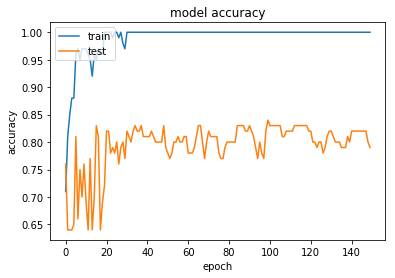

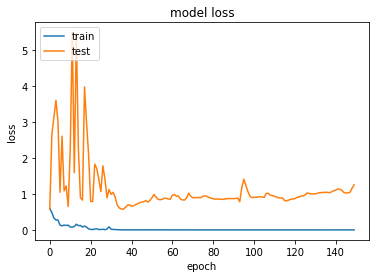

In [27]:
trainStep('GAF')

dimension before: (100, 96, 96)
dimension after: (100, 96, 96, 1)
build conv_x
input shape (96, 96, 1)
build conv_y


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (8, 1), padding="same")`
  import sys
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 1), padding="same")`
  if sys.path[0] == '':
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`


build conv_z
Merging skip connection
build conv_x


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


build conv_y
build conv_z


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`


Merging skip connection
build conv_x
build conv_y


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


build conv_z
Merging skip connection
        -- model was built.


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


train start....


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 100 samples, validate on 100 samples
Epoch 1/150
 - 7s - loss: 0.7715 - acc: 0.5700 - val_loss: 3.9684 - val_acc: 0.3700
Epoch 2/150
 - 3s - loss: 0.5744 - acc: 0.7300 - val_loss: 2.1829 - val_acc: 0.4100
Epoch 3/150
 - 3s - loss: 0.4733 - acc: 0.8100 - val_loss: 0.9401 - val_acc: 0.6500
Epoch 4/150
 - 3s - loss: 0.3722 - acc: 0.8000 - val_loss: 1.9757 - val_acc: 0.6400
Epoch 5/150
 - 3s - loss: 0.3217 - acc: 0.8700 - val_loss: 2.8425 - val_acc: 0.3700
Epoch 6/150
 - 3s - loss: 0.3924 - acc: 0.8600 - val_loss: 1.2686 - val_acc: 0.7100
Epoch 7/150
 - 3s - loss: 0.3778 - acc: 0.8300 - val_loss: 0.9414 - val_acc: 0.7100
Epoch 8/150
 - 3s - loss: 0.3750 - acc: 0.8500 - val_loss: 5.7101 - val_acc: 0.6400
Epoch 9/150
 - 3s - loss: 0.2344 - acc: 0.9100 - val_loss: 0.7715 - val_acc: 0.6900
Epoch 10/150
 - 3s - loss: 0.1919 - acc: 0.9400 - val_loss: 3.2976 - val_acc: 0.6400
Epoch 11/150
 - 3s - loss: 0.2242 - acc: 0.9100 - val_loss: 5.7619 - val_acc: 0.6400
Epoch 12/150
 - 3s - loss: 0

Epoch 97/150
 - 3s - loss: 7.9163e-04 - acc: 1.0000 - val_loss: 0.9065 - val_acc: 0.7100
Epoch 98/150
 - 3s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9023 - val_acc: 0.6800
Epoch 99/150
 - 3s - loss: 7.6626e-04 - acc: 1.0000 - val_loss: 0.9106 - val_acc: 0.6800
Epoch 100/150
 - 3s - loss: 0.0091 - acc: 1.0000 - val_loss: 1.5377 - val_acc: 0.6400
Epoch 101/150
 - 3s - loss: 0.0094 - acc: 1.0000 - val_loss: 3.8775 - val_acc: 0.4500
Epoch 102/150
 - 3s - loss: 0.0037 - acc: 1.0000 - val_loss: 4.3946 - val_acc: 0.3800
Epoch 103/150
 - 3s - loss: 0.0039 - acc: 1.0000 - val_loss: 2.6200 - val_acc: 0.5100
Epoch 104/150
 - 3s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.9717 - val_acc: 0.7200
Epoch 105/150
 - 3s - loss: 0.0044 - acc: 1.0000 - val_loss: 1.0120 - val_acc: 0.7100
Epoch 106/150
 - 3s - loss: 8.2811e-04 - acc: 1.0000 - val_loss: 1.0191 - val_acc: 0.7000
Epoch 107/150
 - 3s - loss: 3.2452e-04 - acc: 1.0000 - val_loss: 1.0159 - val_acc: 0.7100
Epoch 108/150
 - 3s - loss: 4.5186e-04 - 

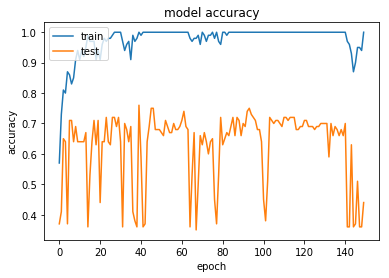

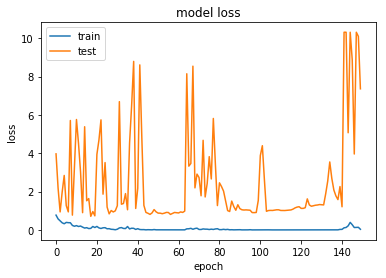

In [28]:
trainStep('MTF')

dimension before: (100, 94, 94)
dimension after: (100, 94, 94, 1)
build conv_x
input shape (94, 94, 1)


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (8, 1), padding="same")`
  import sys
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 1), padding="same")`
  if sys.path[0] == '':
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), padding="same")`


build conv_y
build conv_z


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


Merging skip connection
build conv_x
build conv_y
build conv_z


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Merging skip connection
build conv_x
build conv_y


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (8, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 1), padding="same")`


build conv_z


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), padding="same")`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Merging skip connection
        -- model was built.
train start....
Train on 100 samples, validate on 100 samples
Epoch 1/150
 - 7s - loss: 0.6737 - acc: 0.5900 - val_loss: 1.2797 - val_acc: 0.3600
Epoch 2/150
 - 3s - loss: 0.5810 - acc: 0.6900 - val_loss: 0.9896 - val_acc: 0.3800
Epoch 3/150
 - 3s - loss: 0.5979 - acc: 0.6900 - val_loss: 0.5974 - val_acc: 0.6900
Epoch 4/150
 - 3s - loss: 0.5710 - acc: 0.7400 - val_loss: 1.1355 - val_acc: 0.3900
Epoch 5/150
 - 3s - loss: 0.5321 - acc: 0.7400 - val_loss: 0.8178 - val_acc: 0.5000
Epoch 6/150
 - 3s - loss: 0.5077 - acc: 0.7500 - val_loss: 0.5564 - val_acc: 0.7300
Epoch 7/150
 - 3s - loss: 0.4744 - acc: 0.7400 - val_loss: 0.5159 - val_acc: 0.7300
Epoch 8/150
 - 3s - loss: 0.4486 - acc: 0.7900 - val_loss: 0.8287 - val_acc: 0.6700
Epoch 9/150
 - 3s - loss: 0.3857 - acc: 0.8700 - val_loss: 0.5162 - val_acc: 0.7500
Epoch 10/150
 - 3s - loss: 0.3477 - acc: 0.8100 - val_loss: 1.2294 - val_acc: 0.6400
Epoch 11/150
 - 3s - loss: 0.3580 - acc: 0.81

 - 3s - loss: 0.0762 - acc: 0.9800 - val_loss: 1.7210 - val_acc: 0.6200
Epoch 97/150
 - 3s - loss: 0.1094 - acc: 0.9800 - val_loss: 8.0326 - val_acc: 0.3600
Epoch 98/150
 - 3s - loss: 0.1097 - acc: 0.9500 - val_loss: 1.4835 - val_acc: 0.7800
Epoch 99/150
 - 3s - loss: 0.1077 - acc: 0.9400 - val_loss: 5.2321 - val_acc: 0.6400
Epoch 100/150
 - 3s - loss: 0.0779 - acc: 0.9900 - val_loss: 5.2614 - val_acc: 0.6400
Epoch 101/150
 - 3s - loss: 0.0260 - acc: 1.0000 - val_loss: 2.6319 - val_acc: 0.6600
Epoch 102/150
 - 3s - loss: 0.0398 - acc: 0.9900 - val_loss: 2.0441 - val_acc: 0.6700
Epoch 103/150
 - 3s - loss: 0.0260 - acc: 1.0000 - val_loss: 1.7095 - val_acc: 0.6800
Epoch 104/150
 - 3s - loss: 0.0265 - acc: 1.0000 - val_loss: 1.1926 - val_acc: 0.7500
Epoch 105/150
 - 3s - loss: 0.0172 - acc: 1.0000 - val_loss: 1.1091 - val_acc: 0.7200
Epoch 106/150
 - 3s - loss: 0.0127 - acc: 1.0000 - val_loss: 1.2965 - val_acc: 0.6700
Epoch 107/150
 - 3s - loss: 0.0233 - acc: 1.0000 - val_loss: 0.9342 - v

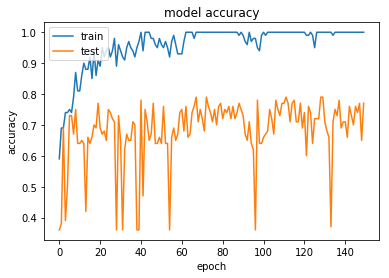

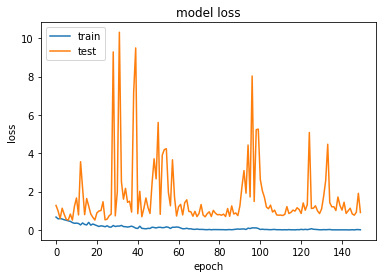

In [29]:
trainStep('RP')